In [1]:
%matplotlib notebook

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.metrics import pairwise_distances

In [3]:
orig_df = df = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv')
df = pd.concat([df, pd.get_dummies(df['gender'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['country'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['state'])], axis=1)
print(df.columns)
df.head()

Index(['10k', 'name', 'division', '25k', 'gender', 'age', 'official', 'bib',
       'genderdiv', 'ctz',
       ...
       'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', 'YT'],
      dtype='object', length=169)


,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,TN,TX,UT,VA,VT,WA,WI,WV,WY,YT
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,0,0,0,0,0,0,0,0,0,0
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,0,0,0,0,0,0,0,0,0,0
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,0,0,0,0,0,0,0,0,0,0
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,0,0,0,0,0,0,0,0,0,0
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,0,0,0,0,0,0,0,0,0,0


In [4]:
quants = df[['5k', '10k', '20k', '25k', 'half', '30k', '35k', '40k', 'official', 'age', 'pace']]
for col in quants:
    quants[col] = quants[col].apply(lambda v: float(v) if v != '-' else float('nan'))
    df[col] = quants[col] = quants[col].fillna(quants[col].mean())
#     quants.loc(pd.isnull(quants[col]))
quants.describe()

C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,5k,10k,20k,25k,half,30k,35k,40k,official,age,pace
count,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000
mean,25.755559,51.799275,105.711669,133.612055,111.664566,164.571219,196.857605,229.001490,242.997314,42.407079,9.275658
std,4.324310,8.958502,19.764747,25.510376,21.037468,33.932444,41.956788,49.129921,52.300431,11.316496,1.992486
min,7.750000,16.620000,36.100000,45.800000,38.030000,56.450000,67.420000,76.100000,80.600000,18.000000,3.080000
25%,22.650000,45.420000,91.770000,115.570000,96.870000,140.695000,167.150000,193.830000,205.527500,33.000000,7.850000
50%,25.100000,50.350000,102.180000,129.070000,107.880000,157.780000,188.220000,218.900000,232.370000,42.000000,8.870000
75%,28.455000,57.150000,116.480000,147.555000,123.030000,182.785000,220.120000,257.405000,273.235000,50.000000,10.430000
max,86.950000,112.380000,224.350000,289.020000,236.670000,376.380000,449.330000,508.350000,538.880000,81.000000,20.570000


In [35]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Make sure the number of rows divides evenly into four samples.
rows = df.shape[0] - df.shape[0] % 4
quants = quants.iloc[:rows, :]

# Break into a set of features and a variable for the known outcome.
X = quants.iloc[:, :11]

# Replace some random string values.
X = X.replace(to_replace='?', value=0)

# Normalize
X_norm = normalize(X)

# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 10):
        pred = KMeans(n_clusters=nclust, random_state=42).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

<IPython.core.display.Javascript object>


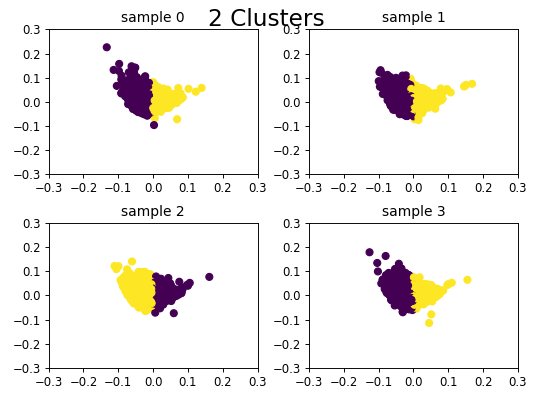

<IPython.core.display.Javascript object>


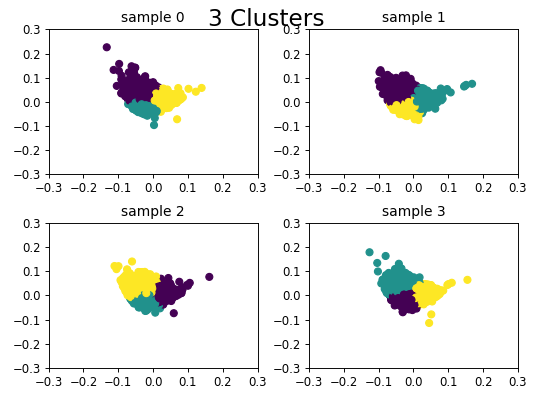

<IPython.core.display.Javascript object>


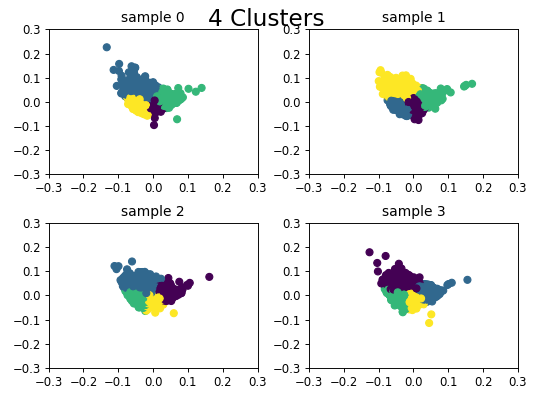

<IPython.core.display.Javascript object>


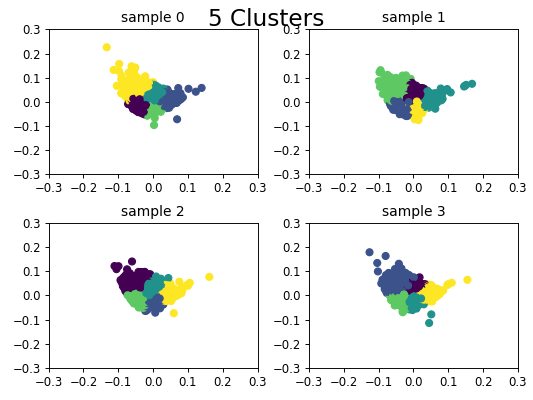

<IPython.core.display.Javascript object>


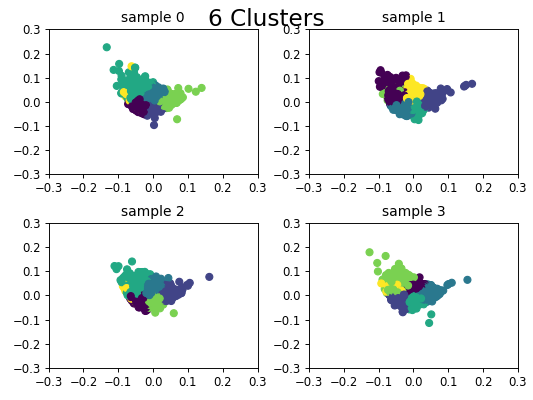

<IPython.core.display.Javascript object>


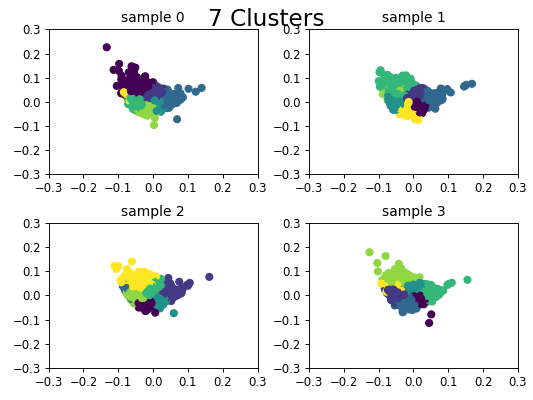

<IPython.core.display.Javascript object>


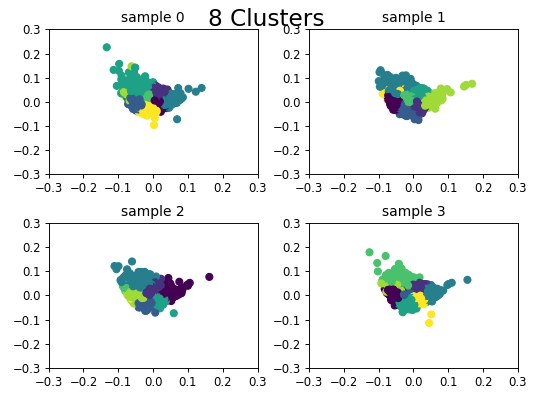

<IPython.core.display.Javascript object>


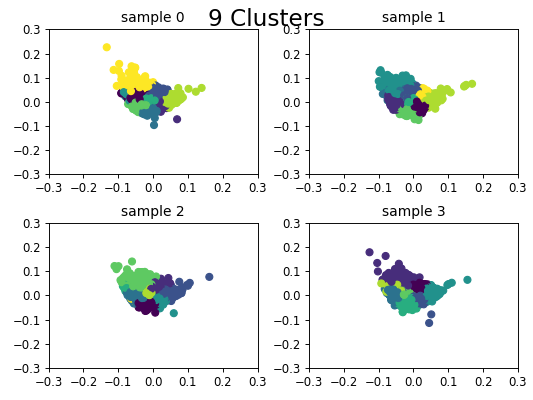

In [36]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 10):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

In [5]:
from sklearn.cluster import SpectralClustering, MiniBatchKMeans, KMeans

In [ ]:
#loop through clusters and samples to see silhouette score
clust_start = 2
clust_end = 151
sils = []

for nclust in range(clust_start, clust_end):
    sils.append([nclust])

    for counter, sample in enumerate([X1, X2, X3, X4]): 
        model = KMeans(n_clusters=nclust, random_state=42).fit(sample)
        labels = model.labels_
        sils.append([metrics.silhouette_score(sample, labels, metric='euclidean')])

a = np.reshape(sils,(clust_end - clust_start,5))
sil_scores = pd.DataFrame(a.tolist())

<IPython.core.display.Javascript object>


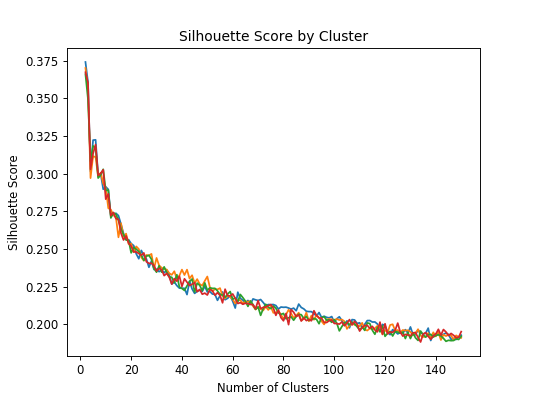

Text(0.5,1,'Silhouette Score by Cluster')

In [127]:
plt.figure()
plt.plot(sil_scores[0], sil_scores[1])
plt.plot(sil_scores[0], sil_scores[2])
plt.plot(sil_scores[0], sil_scores[3])
plt.plot(sil_scores[0], sil_scores[4])
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by Cluster')

In [ ]:
df['cluster_2_sc'] = SpectralClustering(10, n_jobs=-1).fit_predict(quants.values)

In [ ]:
df['cluster_2_km'] = MiniBatchKMeans(2, verbose=True).fit_predict(quants.values)

In [ ]:
df.corr()['cluster_2_km'].sort_values()

In [ ]:
plt.figure()
plt.scatter(df['official'], df['country'], c=df['cluster_2_km'])

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np
from tqdm import tqdm_notebook as tqdm

xs = np.logspace(-1, 3, 20)
ys = [DBSCAN(eps=x, n_jobs=-1).fit_predict(quants.values).ptp() for x in tqdm(xs)]

In [ ]:
plt.figure()
plt.plot(xs, ys)
plt.xscale('log')

In [ ]:
from sklearn.manifold import TSNE

plt.figure()
plt.scatter(*TSNE(2, verbose=11).fit_transform(quants.values).T)

In [ ]:
plt.figure()
plt.scatter(df['age'], df['40k'], c=df['gender'].apply(lambda g: g == 'M'), s=10, alpha=0.1)

In [ ]:
plt.figure()
plt.scatter(df['age'], df['pace'], alpha=0.1)